In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms as tfs
from torchvision.datasets import MNIST
from torchvision import models

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!ls

characters_illustration.png  sample_data	    testset
gdrive			     sample_submission.csv  train


In [ ]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Dec 15 18:38 /content/gdrive/MyDrive/journey-springfield.zip


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset')

In [ ]:
batch_size = 32
rescale_size = 244

# предобученные модели в torchvision ожидают увидеть нормализацию изображений с данными параметрами:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:

transform = tfs.Compose([
    # один из видов агументации данных: выбор рандомного подкадра 
    tfs.Resize((int(rescale_size * 1.25), int(rescale_size * 1.25))),
    tfs.RandomCrop(rescale_size),

    # отражение картинок
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize(mean, std)
])

dataset_full = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)

train_idx, valid_idx = train_test_split(list(range(len(dataset_full))), train_size=0.95)
dataset = {
    'train': torch.utils.data.Subset(dataset_full, train_idx),
    'valid': torch.utils.data.Subset(dataset_full, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}
dataset_classes = np.array(dataset_full.classes)
print('classes:', dataset_classes, '\nsize', dataset_size)

train_loader = torch.utils.data.DataLoader(dataset=dataset['train'], batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(dataset=dataset['valid'], batch_size=batch_size, shuffle=False, num_workers=2)

loaders = {"train": train_loader, "valid": valid_loader}

classes: ['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'snake_jailbird' 'troy_mcclure' 'waylon_smithers'] 
size {'train': 19886, 'valid': 1047}


In [ ]:
len(dataset_classes)

42

In [ ]:
transform = tfs.Compose([
    tfs.CenterCrop(rescale_size),
    tfs.ToTensor(),
    tfs.Normalize(mean, std)
])

dataset_test = torchvision.datasets.ImageFolder(
    root=TEST_DIR,
    transform=transform
)

dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=batch_size)
test_filenames = [fn[0].split('/')[-1] for fn in dataset_test.imgs]

In [ ]:
next(iter(loaders['train']))[0].shape

torch.Size([32, 3, 244, 244])

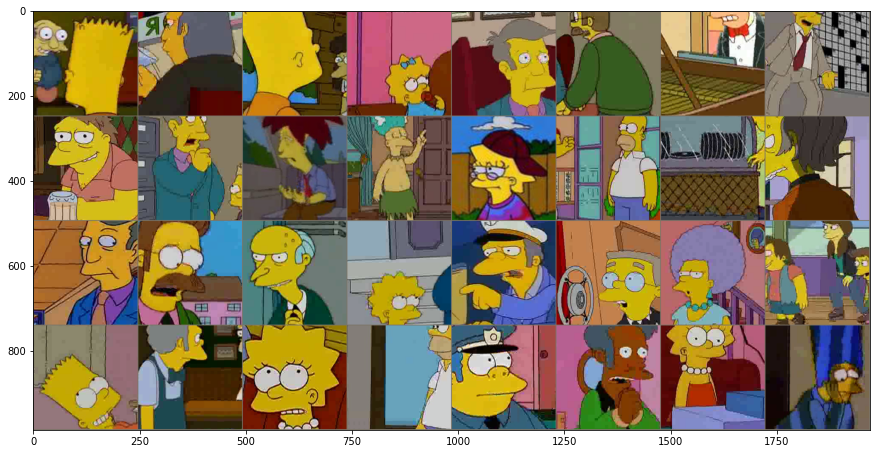

In [ ]:
def imshow(inp, title=None):
    """функция для отрицсовки батча (взята из семинара по дообучению)"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    model.to(device) 
    # переменные для сохранения параметров модели с наилучшей точностью
    best_model_wts = model.state_dict()
    best_acc = 0.0

    accuracy = {"train": [], "valid": []}

    for epoch in range(num_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(outp)
                epoch_correct += correct.item()
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            if k == "train":
                scheduler.step()
                print(f"Epoch: {epoch+1}")
            epoch_acc = epoch_correct/epoch_all
            print(f"Loader: {k}. Accuracy: {epoch_acc}")
            accuracy[k].append(epoch_acc)

            if k == 'valid' and epoch_acc > best_acc:
              # сохранить лучшие веса модели
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, accuracy

In [ ]:
class Net1(nn.Module):
    # код простой сети, взятый из одной из предыдущих домашек
    def __init__(self):
        super(Net1, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 10, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.BatchNorm2d(10))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 20, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.BatchNorm2d(20))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(20, 40, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(40))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(40, 40, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(40))
        
        self.fc1 = nn.Sequential(
            nn.Linear(1440, 120),
            nn.ReLU(),
            nn.Dropout(p=0.3))
        
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2))
        
        self.fc3 = nn.Linear(84, 42)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(x.shape)
        x = x.view(-1, 1440)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = Net1()
# точность 83%

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model = models.vgg16(pretrained=True)
# лучший результат был получен при разморозке 6 последних слоев и 25 эпохах обучения

# for param in model.features[:6].parameters():
#     param.requires_grad = False

model.classifier = nn.Linear(25088, 42)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model = models.alexnet(pretrained=True)
# низкая точность

# (classifier): Sequential(
#     (0): Dropout(p=0.5, inplace=False)
#     (1): Linear(in_features=9216, out_features=4096, bias=True)
#     (2): ReLU(inplace=True)
#     (3): Dropout(p=0.5, inplace=False)
#     (4): Linear(in_features=4096, out_features=4096, bias=True)
#     (5): ReLU(inplace=True)
#     (6): Linear(in_features=4096, out_features=1000, bias=True)
# )

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=42, bias=True)
)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model, accuracy = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch: 1
Loader: train. Accuracy: 0.1031378859499145
Loader: valid. Accuracy: 0.09073543457497613
Epoch: 2
Loader: train. Accuracy: 0.1077642562606859
Loader: valid. Accuracy: 0.09073543457497613
Epoch: 3
Loader: train. Accuracy: 0.10811626269737504
Loader: valid. Accuracy: 0.09073543457497613
Epoch: 4
Loader: train. Accuracy: 0.10816654933118777
Loader: valid. Accuracy: 0.09073543457497613


KeyboardInterrupt: ignored

In [ ]:
PATH = '/content/gdrive/MyDrive/SavedModels/Simpsons/VGG.pt'

In [ ]:
PATH = '/content/gdrive/MyDrive/SavedModels/Simpsons/model1.pt'

In [ ]:
PATH = '/content/gdrive/MyDrive/SavedModels/Simpsons/alexnet.pt'

In [ ]:
torch.save(model, PATH)
# сохранение весов на диск

In [ ]:
def predict(model, dataloader_test):
    """функция предсказания по dataloader"""
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in tqdm(dataloader_test):
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_to_submission(model, dataloader_test=dataloader_test, test_filenames=test_filenames, dataset_classes=dataset_classes):
    """запись предсказаний в файл для отпраки на kaggle"""
    probs = predict(model, dataloader_test)
    print(probs.shape)
    predictions = np.argmax(probs, axis=1)
    preds = dataset_classes[predictions]
    submission = pd.read_csv('/content/sample_submission.csv')
    submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds}).sort_values('Id')
    submission.to_csv('/content/gdrive/MyDrive/submission.csv', index=False)

In [ ]:
predict_to_submission(model)

лучший скор на kaggle: 0.92561
(дообучение 6 последний слоев VGG16)